In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

np.seterr(divide='ignore');

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

$$\vec{E} = q \left[\frac{\hat R - \vec{\beta}}{\gamma ^2 I^3 R^2} \right]_\text{del}+ \frac{q}{c} \left[ \frac{\hat R \times \left( \left( \hat R - \vec{\beta} \right) \times \vec{\dot{\beta}} \right)}{I^3 R} \right]_\text{del}$$

$$\vec B = \hat R \times \vec E$$

where $$I \equiv 1-\vec\beta \cdot \hat R$$

and $$\vec R = \vec x - \vec r (t)$$

- Particle motion $\vec r (t)$ is in the x-y plane
- Find the field within the $z=0$ plane

In [15]:
# parameters
q = 1
c = 1
alpha = 0.1
omega = 0.9
t_start = 3.
tol = 1e-6
delay_scale = 10
tsteps = 1000
t_max = 12.

range_factor = 2.

In [16]:
# define trajectory function
def trajectory(t_arr : np.ndarray, t_start : float):
    # rx = np.where(t_arr > t_start, alpha * (t_arr - t_start)**2, 0.)
    rx = np.where(t_arr > t_start, 1. * np.cos(omega * (t_arr - t_start)), 1.)
    ry = np.where(t_arr > t_start, 1. * np.sin(omega * (t_arr - t_start)), 0.)
    # ry = np.zeros_like(t_arr)
    rz = np.zeros_like(t_arr)

    return np.hstack((rx[:,None], ry[:,None], rz[:,None]))

In [17]:
t_array = np.linspace(0., t_max, tsteps)
dt = t_array[1] - t_array[0]

r = trajectory(t_array, t_start=t_start)
# r_norm = np.linalg.norm(r, axis=1)[:,None]
# rhat = r / r_norm
# rhat = np.nan_to_num(rhat, 0.)

beta = np.gradient(r, axis=0, edge_order=2) / dt
beta_dot = np.gradient(beta, axis=0, edge_order=2) / dt
# I_vec = 1. - np.sum(beta * rhat, axis=1)

# observed field space
x_max = np.linalg.norm(r[-1])
x = np.linspace(-range_factor * x_max, range_factor * x_max, 20)
z = np.linspace(0,0,1)
xx, yy, zz = np.meshgrid(x,x,z)
x_vec = np.concat([xx[None], yy[None], zz[None]])

# making an R tensor would take too much memory

# assert rhat.shape == r.shape
assert beta.shape == r.shape
assert beta_dot.shape == r.shape
# assert x_vec.shape == (3, x.shape[0], x.shape[0], z.shape[0])
# assert I_vec.shape[0] == r.shape[0]

In [25]:
def E(x_vec, r, beta, beta_dot, i):
    '''
    Calculate the electric field due to a moving charge
    with trajectory r at time index i.
    '''
    R = x_vec - r[i][:,None,None,None]

    R_norm = np.linalg.norm(R, axis=0)
    R_hat = np.nan_to_num(R / R_norm[None], 0.)

    delayed_i = i - np.clip((R_norm*delay_scale).astype('int'), a_min=0, a_max=tsteps)

    beta_d = np.transpose(beta[delayed_i], (3,0,1,2))
    gamma2 = 1. / (1 - np.sum(beta_d * beta_d, axis=0))
    beta_dot_d = np.transpose(beta_dot[delayed_i], (3,0,1,2))
    I = 1. - np.sum(beta_d * R_hat, axis=0)

    term1 = (R_hat - beta_d) / (gamma2[None] * I[None]**3 * R_norm[None]**3)

    rhat_minus_b_cross_bdot = np.cross((R_hat - beta_d), beta_dot_d, axis=0)
    term2 = np.cross(R_hat, rhat_minus_b_cross_bdot, axis=0) / (I[None]**3 * R_norm[None])

    return term1 + term2


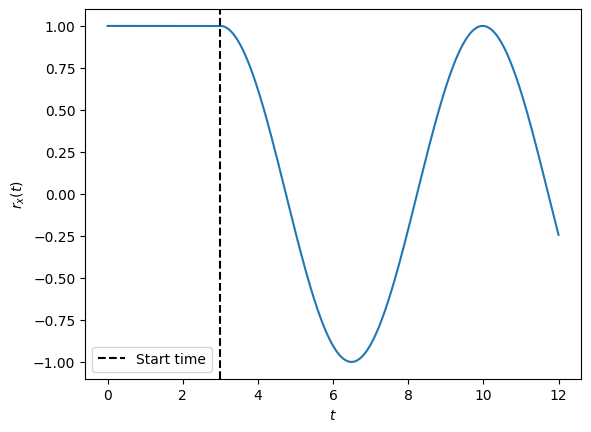

In [26]:
plt.plot(t_array, r[:,0])
plt.xlabel('$t$')
plt.ylabel('$r_x(t)$')
plt.axvline(t_start, c='k', ls='--', label='Start time')
plt.legend()

# if np.any(r[-1] > x.max()):
    # print('Warning: particle leaves bounds where fields are calculated')

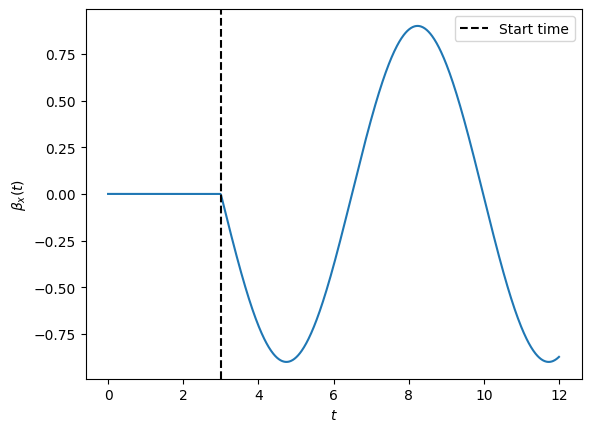

In [27]:
plt.plot(t_array, beta[:,0])
plt.xlabel('$t$')
plt.ylabel('$\\beta_x(t)$')
plt.axvline(t_start, c='k', ls='--', label='Start time')
plt.legend()

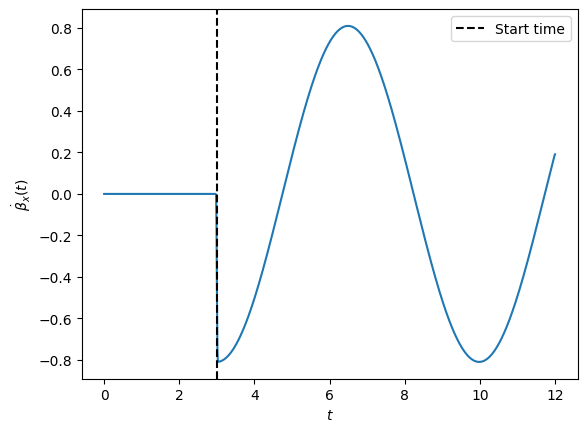

In [28]:
plt.plot(t_array, beta_dot[:,0])
plt.xlabel('$t$')
plt.ylabel('$\\dot{\\beta}_x(t)$')
plt.axvline(t_start, c='k', ls='--', label='Start time')
plt.legend()

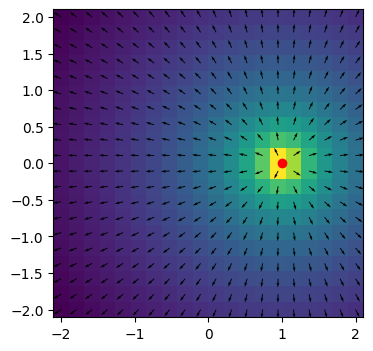

In [29]:
i = 100
E0 = E(x_vec, r, beta, beta_dot, i)
E0_norm = np.linalg.norm(E0, axis=0)
E0_normed = np.nan_to_num(E0 / E0_norm[None], 0.)

plt.figure(figsize=(4,4))
plt.pcolormesh(xx[:,:,0], yy[:,:,0], np.log10(E0_norm[:,:,0]))
# plt.streamplot(xx[:,:,0], yy[:,:,0], E0_normed[0,:,:,0], E0_normed[1,:,:,0], color='k')
plt.quiver(xx[:,:,0], yy[:,:,0], E0_normed[0,:,:,0], E0_normed[1,:,:,0], )
plt.scatter(r[i,0], r[i,1], c='r')

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

# first frame
i = 0
E0 = E(x_vec, r, beta, beta_dot, i)
E0_norm = np.linalg.norm(E0, axis=0)
E0_normed = np.nan_to_num(E0 / E0_norm[None], 0.)


cmesh = ax.pcolormesh(xx[:,:,0], yy[:,:,0], np.log10(E0_norm[:,:,0]))
quiv = ax.quiver(xx[:,:,0], yy[:,:,0], E0_normed[0,:,:,0], E0_normed[1,:,:,0], )
charge = ax.scatter(r[i,0], r[i,1], c='r')

t = t_array[i]
title = ax.set_title(f't = {t:.3}')

def update(i):
    E0 = E(x_vec, r, beta, beta_dot, i)
    E0_norm = np.linalg.norm(E0, axis=0)
    E0_normed = np.nan_to_num(E0 / E0_norm[None], 0.)

    cmesh.set_array(np.log10(E0_norm[:,:,0]))
    # cmesh.set_array(np.log10(E0_norm[:,:,0]))
    quiv.set_UVC(E0_normed[0,:,:,0], E0_normed[1,:,:,0])
    charge.set_offsets(np.c_[r[i,0], r[i,1]])
    t = t_array[i]
    title.set_text(f't = {t:.3}')

    return cmesh, quiv, charge, title


fps = 30
animation = anim.FuncAnimation(
    fig,
    update,
    frames = t_array.shape[0],
    interval = 1000 / fps
)

animation.save('charge3.gif', fps=fps)